In [2]:
%load_ext watermark
from IPython.display import clear_output 
clear_output()
%watermark -a "Romell D.Z.(@romellfudi) Software Engineer, Business Intelligence Analist and Data Scientist" -iv  -u -d

Author: Romell D.Z.(@romellfudi) Software Engineer, Business Intelligence Analist and Data Scientist

Last updated: 2023-09-15



# 7. Transfer Learning

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,6)

## Load Dataset from KAGGLE DATA BASE

In [ ]:
import os
import glob
import zipfile
import functools

# Upload the API token.
def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file
        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see: "
                           "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()

import kaggle

# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(competition, file):
    with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(competition)

def load_data_from_7z(competition, file):
    os.system( '7z x %s ' % os.path.join(competition, file) )

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train.zip')

Saving kaggle.json to kaggle.json


In [ ]:
competition = 'dogs-vs-cats'
get_data(competition)

## LOAD ALL PICS DOG & CATS FROM ANIMALS TRAIN FOLDER

In [ ]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)

In [ ]:
files = glob.glob('%s/train/*'%competition)

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(25000, 25000)

## select 1500 pics for train sample, 500 validation sample, 500 for test sample

In [ ]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


## puts this samples into news folders

In [ ]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [ ]:
import os
os.sep

'/'

## Load each folder on RAM MEMORY

In [ ]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split(os.sep)[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split(os.sep)[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (2905, 150, 150, 3) 	Validation dataset shape: (989, 150, 150, 3)


## Allways need scale(normalization): generating a better performance

(150, 150, 3)


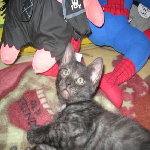

In [ ]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

## Encoding LABEL prectitions using One Hot Encoding

In [ ]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat'] [1 0 0 1 1 1 0 0 1 0]


## Build Model 1 using Convolution Layers

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flat

In [ ]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 2916 samples, validate on 993 samples
Epoch 1/30
2916/2916 [==============================] - 11s 4ms/step - loss: 0.8053 - acc: 0.5628 - val_loss: 1.0819 - val_acc: 0.5065
Epoch 2/30
2916/2916 [==============================] - 7s 2ms/step - loss: 0.6463 - acc: 0.6488 - val_loss: 0.6257 - val_acc: 0.6526
Epoch 3/30
2916/2916 [==============================] - 7s 2ms/step - loss: 0.5672 - acc: 0.7109 - val_loss: 0.7008 - val_acc: 0.5720
Epoch 4/30
2916/2916 [==============================] - 7s 2ms/step - loss: 0.5064 - acc: 0.7507 - val_loss: 0.5800 - val_acc: 0.6858
Epoch 5/30
2916/2916 [==============================] - 7s 2ms/step - loss: 0.4324 - acc: 0.7946 - val_loss: 0.5795 - val_acc: 0.6818
Epoch 6/30
2916/2916 [==============================] - 7s 2ms/step - loss: 0.3468 - acc: 0.8474 - val_loss: 0.6050 - val_acc: 0.7059
Epoch 7/30
2916/2916 [==============================] - 7s 2ms/step - loss: 0.2647 - acc: 0.8858 - v

## Model 1 Basic Convolution Neural Network

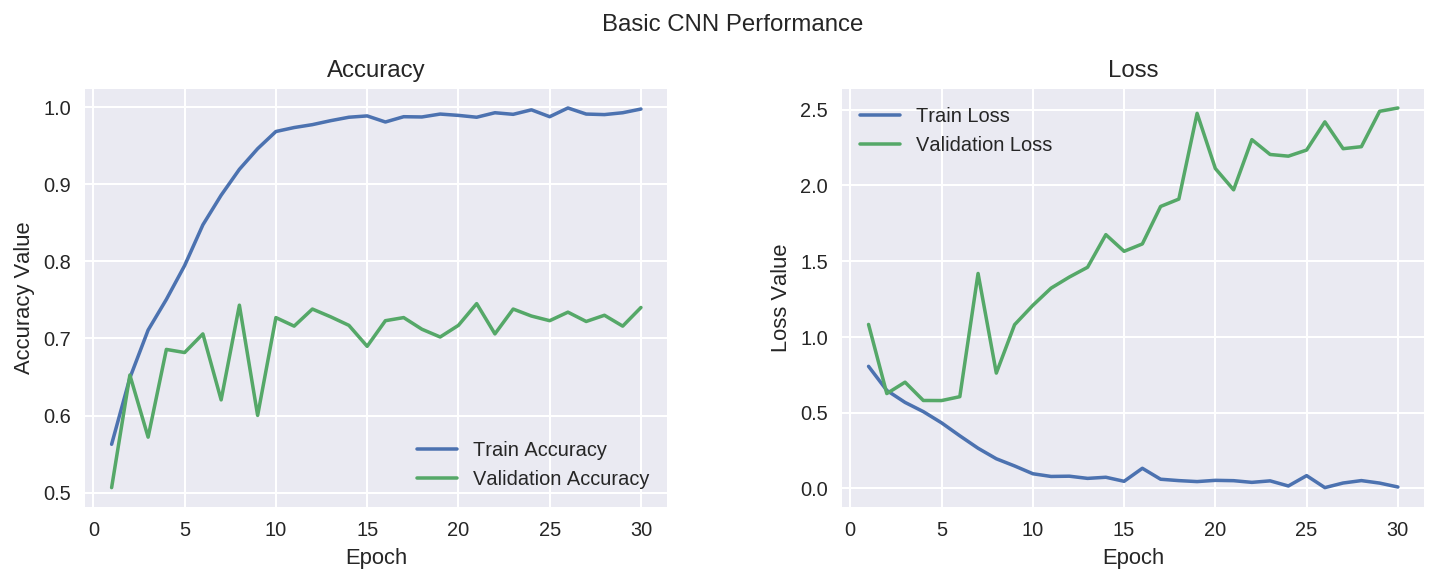

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [ ]:
model.save('cats_dogs_basic_without_dropout.h5')

## Model 2 CNN with Dropout layers

In [ ]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2916 samples, validate on 993 samples
Epoch 1/30
2916/2916 [==============================] - 6s 2ms/step - loss: 0.7244 - acc: 0.5041 - val_loss: 0.6920 - val_acc: 0.4935
Epoch 2/30
2916/2916 [==============================] - 6s 2ms/step - loss: 0.6939 - acc: 0.5487 - val_loss: 2.2433 - val_acc: 0.4935
Epoch 3/30
2916/2916 [==============================] - 6s 2ms/step - loss: 0.6711 - acc: 0.6337 - val_loss: 0.6448 - val_acc: 0.6576
Epoch 4/30
2916/2916 [==============================] - 6s 2ms/step - loss: 0.5867 - acc: 0.6996 - val_loss: 0.5880 - val_acc: 0.6697
Epoch 5/30
2916/2916 [==============================] - 6s 2ms/step - loss: 0.5274 - acc: 0.7548 - val_loss: 0.5787 - val_acc: 0.7412
Epoch 6/30
2916/2916 [==============================] - 6s 2ms/step - loss: 0.4785 - acc: 0.7781 - val_loss: 0.5449 - val_acc: 0.7200
Epoch 7/30
2916/2916 [============

In [ ]:
model.save('cats_dogs_basic_cnn.h5')

## Build Data Augmentation Generator to reduce VARIANCE

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


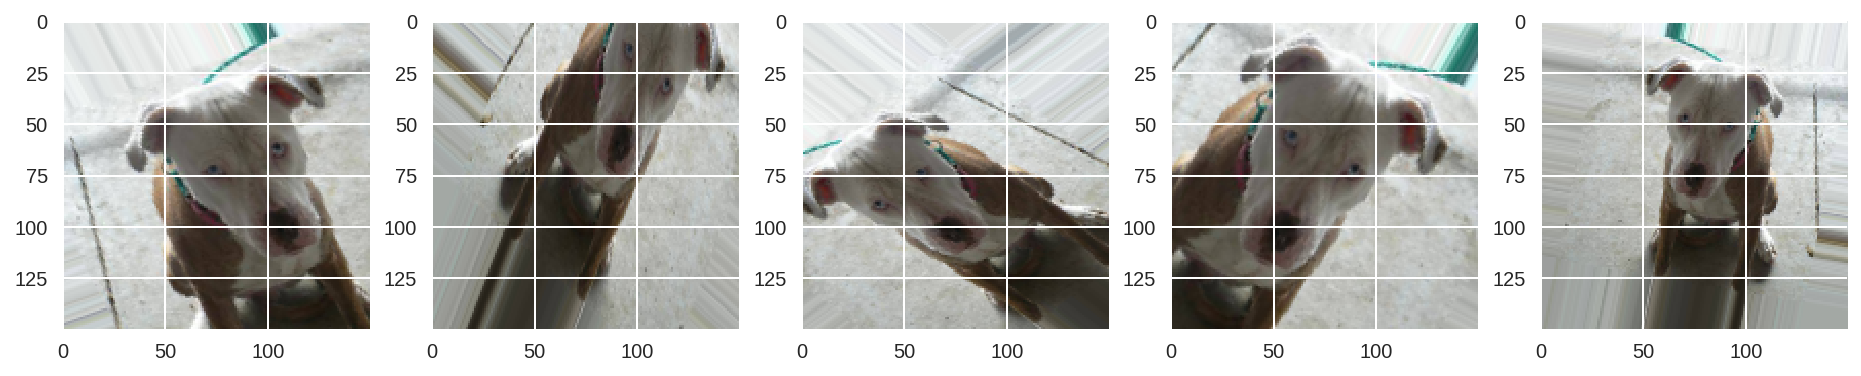

In [ ]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


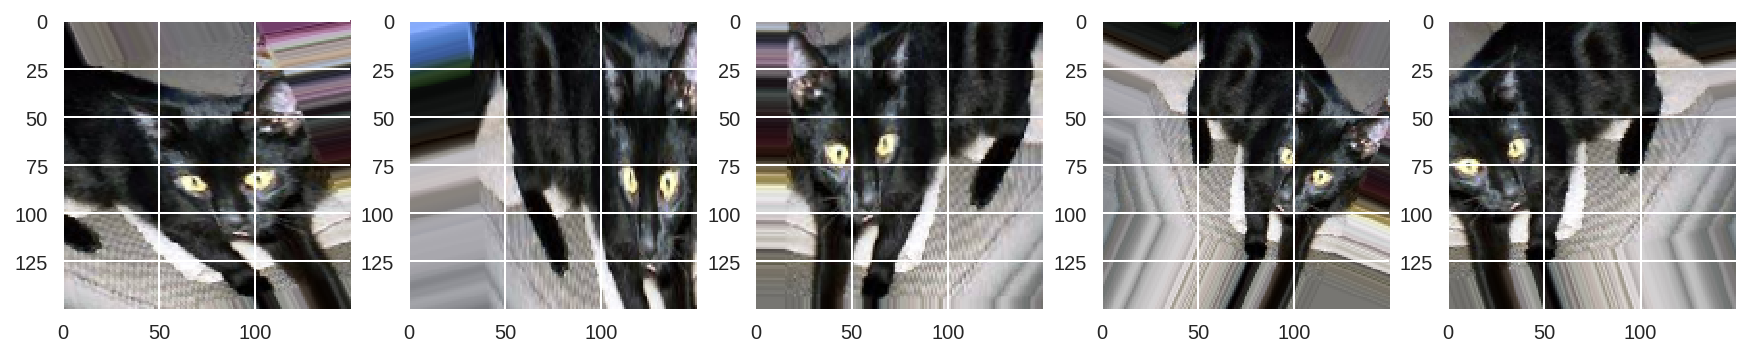

In [ ]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

## Model 3 CNN with Dropout layers using Data Augmentation Generator

In [ ]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1) 

Epoch 1/100
100/100 [==============================] - 20s 196ms/step - loss: 0.6923 - acc: 0.5127 - val_loss: 0.6859 - val_acc: 0.5509
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 0.6846 - acc: 0.5630 - val_loss: 0.6694 - val_acc: 0.6113
Epoch 3/100
100/100 [==============================] - 18s 182ms/step - loss: 0.6763 - acc: 0.5726 - val_loss: 0.6758 - val_acc: 0.5498
Epoch 4/100
100/100 [==============================] - 18s 178ms/step - loss: 0.6653 - acc: 0.5980 - val_loss: 0.6707 - val_acc: 0.5730
Epoch 5/100
100/100 [==============================] - 18s 178ms/step - loss: 0.6601 - acc: 0.6007 - val_loss: 0.6347 - val_acc: 0.6334
Epoch 6/100
100/100 [==============================] - 18s 184ms/step - loss: 0.6484 - acc: 0.6180 - val_loss: 0.6515 - val_acc: 0.6093
Epoch 7/100
100/100 [==============================] - 18s 177ms/step - loss: 0.6363 - acc: 0.6313 - val_loss: 0.6082 - val_acc: 0.6606
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('cats_dogs_cnn_img_aug.h5')

## Model 4 Using a VGG16 pre-trained model, adding new outout layers (Transfer Learning)

In [ ]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

58892288/58889256 [==============================] - 2s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f3a8df32f60>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f3a8dde2780>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f3a8df32278>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f3aa0092b00>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f3a8ddce6d8>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f3a88fdecf8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f3a8d02b630>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f3a8d02b518>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f3a8cfdc2b0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f3a8cfee908>,block3_conv3,False


## Testing how VVG6 working

(1, 4, 4, 512)


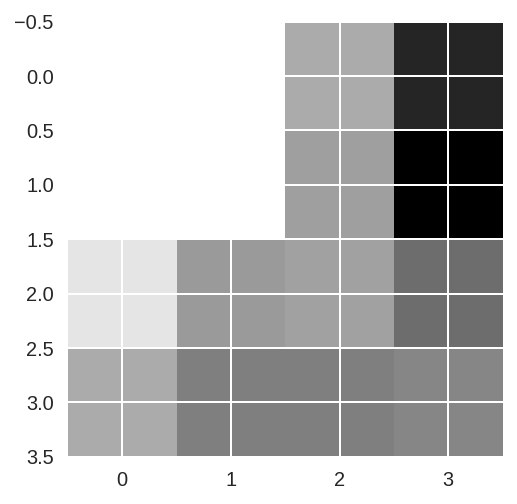

In [ ]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [ ]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (2916, 8192) 	Validation Bottleneck Features: (993, 8192)


## Model 4 Basic Transfer Lerning Neural networks

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 2916 samples, validate on 993 samples
Epoch 1/30
2916/2916 [==============================] - 2s 539us/step - loss: 0.4275 - acc: 0.7966 - val_loss: 0.3040 - val_acc: 0.8550
Epoch 2/30
2916/2916 [==============================] - 1s 316us/step - loss: 0.2872 - acc: 0.8759 - val_loss: 0.2484 - val_acc: 0.8902
Epoch 3/30
2916/2916 [==============================] - 1s 308us/step - loss: 0.2483 - acc: 0.8930 - val_loss: 0.2259 - val_acc: 0.9013
Epoch 4/30
2916/2916 [==============================] - 1s 308us/step - loss: 0.2095 - acc: 0.9122 - val_loss: 0.2150 - val_acc: 0.9114
Epoch 5/30
2916/2916 [==============================] - 1s 312us/step - loss: 0.1696 - acc: 0.9270 - val_loss: 0.2263 - val_acc: 0.9094
Epoch 6/30
2916/2916 [==============================] - 1s 308us/step - loss: 0.1481 - acc: 0.9400 - val_loss: 0.2607 - val_acc: 0.8983
Epoch 7/30
2916/2916 [==============================] - 1s 308us/step - loss: 0.1180 - acc: 0.9540 - val_loss: 0.2187 - val_acc: 0.9164
E

In [ ]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

## Data Augmentation with Re-scaling (Normalization)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)    

Epoch 1/100
100/100 [==============================] - 30s 300ms/step - loss: 0.6549 - acc: 0.6000 - val_loss: 0.4954 - val_acc: 0.8207
Epoch 2/100
100/100 [==============================] - 25s 255ms/step - loss: 0.5680 - acc: 0.7017 - val_loss: 0.3932 - val_acc: 0.8560
Epoch 3/100
100/100 [==============================] - 25s 252ms/step - loss: 0.5345 - acc: 0.7200 - val_loss: 0.3489 - val_acc: 0.8681
Epoch 4/100
100/100 [==============================] - 26s 258ms/step - loss: 0.4851 - acc: 0.7600 - val_loss: 0.3066 - val_acc: 0.8852
Epoch 5/100
100/100 [==============================] - 26s 261ms/step - loss: 0.4564 - acc: 0.7810 - val_loss: 0.2904 - val_acc: 0.8862
Epoch 6/100
100/100 [==============================] - 27s 267ms/step - loss: 0.4411 - acc: 0.7840 - val_loss: 0.2830 - val_acc: 0.8812
Epoch 7/100
100/100 [==============================] - 26s 261ms/step - loss: 0.4128 - acc: 0.8047 - val_loss: 0.2633 - val_acc: 0.8973
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

## Using a Pre-trrainer CNN & clear all weights at 4th and 5th block

In [ ]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f3a8df32f60>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f3a8dde2780>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f3a8df32278>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f3aa0092b00>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f3a8ddce6d8>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f3a88fdecf8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f3a8d02b630>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f3a8d02b518>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f3a8cfdc2b0>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f3a8cfee908>,block3_conv3,False


## Model 5: Tranfer Lerning CNN, DataAugmentation, clean weighs at 4th & 5th layers blocks (fine tunning)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)              

Epoch 1/100
100/100 [==============================] - 34s 341ms/step - loss: 0.5933 - acc: 0.6693 - val_loss: 0.3330 - val_acc: 0.8550
Epoch 2/100
100/100 [==============================] - 32s 316ms/step - loss: 0.4064 - acc: 0.8137 - val_loss: 0.2034 - val_acc: 0.9114
Epoch 3/100
100/100 [==============================] - 32s 317ms/step - loss: 0.3370 - acc: 0.8497 - val_loss: 0.1853 - val_acc: 0.9215
Epoch 4/100
100/100 [==============================] - 32s 317ms/step - loss: 0.2852 - acc: 0.8687 - val_loss: 0.1426 - val_acc: 0.9376
Epoch 5/100
100/100 [==============================] - 32s 316ms/step - loss: 0.2730 - acc: 0.8843 - val_loss: 0.1340 - val_acc: 0.9416
Epoch 6/100
100/100 [==============================] - 32s 317ms/step - loss: 0.2422 - acc: 0.8943 - val_loss: 0.1400 - val_acc: 0.9396
Epoch 7/100
100/100 [==============================] - 32s 316ms/step - loss: 0.2297 - acc: 0.9077 - val_loss: 0.1432 - val_acc: 0.9406
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

## Benchmarking between this 5 models

In [ ]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
basic_cnn = load_model('cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = load_model('cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (990, 150, 150, 3)
['dog', 'dog', 'cat', 'dog', 'dog'] [1, 1, 0, 1, 1]


## Model 1

In [ ]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.7826
Precision: 0.7832
Recall: 0.7826
F1 Score: 0.7826

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.80      0.77      0.78       502
         cat       0.77      0.80      0.78       487

   micro avg       0.78      0.78      0.78       989
   macro avg       0.78      0.78      0.78       989
weighted avg       0.78      0.78      0.78       989


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog  385        117
        cat  98         389


## Model 2

In [ ]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.8342
Precision: 0.8343
Recall: 0.8342
F1 Score: 0.8342

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.84      0.83      0.84       502
         cat       0.83      0.84      0.83       487

   micro avg       0.83      0.83      0.83       989
   macro avg       0.83      0.83      0.83       989
weighted avg       0.83      0.83      0.83       989


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog  416        86 
        cat  78         409


## Model 3

In [ ]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9181
Precision: 0.9181
Recall: 0.9181
F1 Score: 0.9181

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.92      0.92      0.92       502
         cat       0.92      0.92      0.92       487

   micro avg       0.92      0.92      0.92       989
   macro avg       0.92      0.92      0.92       989
weighted avg       0.92      0.92      0.92       989


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog  462        40 
        cat  41         446


## Model 4

In [ ]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9141
Precision: 0.9156
Recall: 0.9141
F1 Score: 0.9139

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.89      0.95      0.92       502
         cat       0.94      0.88      0.91       487

   micro avg       0.91      0.91      0.91       989
   macro avg       0.92      0.91      0.91       989
weighted avg       0.92      0.91      0.91       989


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog  475        27 
        cat  58         429


## Model 5

In [ ]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9838
Precision: 0.9838
Recall: 0.9838
F1 Score: 0.9838

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.98      0.99      0.98       496
         dog       0.99      0.98      0.98       494

   micro avg       0.98      0.98      0.98       990
   macro avg       0.98      0.98      0.98       990
weighted avg       0.98      0.98      0.98       990


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat        489    7
        dog          9  485


## Worst Model - Model 5 - Basic CNN 

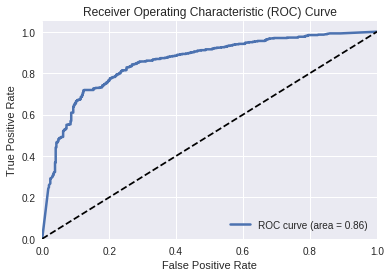

In [ ]:
meu.plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1]) 

## Best model - Model 5 - Transfer Learning with Fine-tuning & Data Augmentation

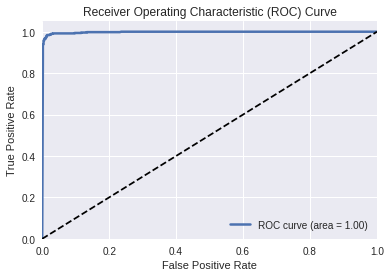

In [ ]:
# best model - transfer learning with fine-tuning & image augmentation 
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])